# Spaceship Titanic Project

This notebook demonstrates end-to-end classification project about Kaggle's Spaceship Titanic dataset. Here is the information from Kaggle:


>In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

**Information about data**: Personal records for about two-thirds (~8700) of the passengers, to be used as training data for this project. You can see the relevant page: https://www.kaggle.com/competitions/spaceship-titanic/data

**Evaluation Metric**:Submissions are evaluated based on their classification accuracy, the percentage of predicted labels that are correct.



### 1. Exploratory Data Analysis

In [ ]:
# Necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Load in the data
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/ml-data/train_spaceship.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.shape

(8693, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
# Identify missing values and decide on a strategy for handling them
missing_values = df.isnull().sum()
print(missing_values)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [ ]:
# Explore the relationships between features and the target variable
feature_correlations = df.corr()['Transported'].abs().sort_values(ascending=False)
print(feature_correlations)

Transported     1.000000
RoomService     0.244611
Spa             0.221131
VRDeck          0.207075
Age             0.075026
FoodCourt       0.046566
ShoppingMall    0.010141
Name: Transported, dtype: float64


<ipython-input-17-0fc59809f149>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_correlations = df.corr()['Transported'].abs().sort_values(ascending=False)


Notice that luxury-related spendings have a higher correlation with the target variable. We can create a new feature out of the total spending.

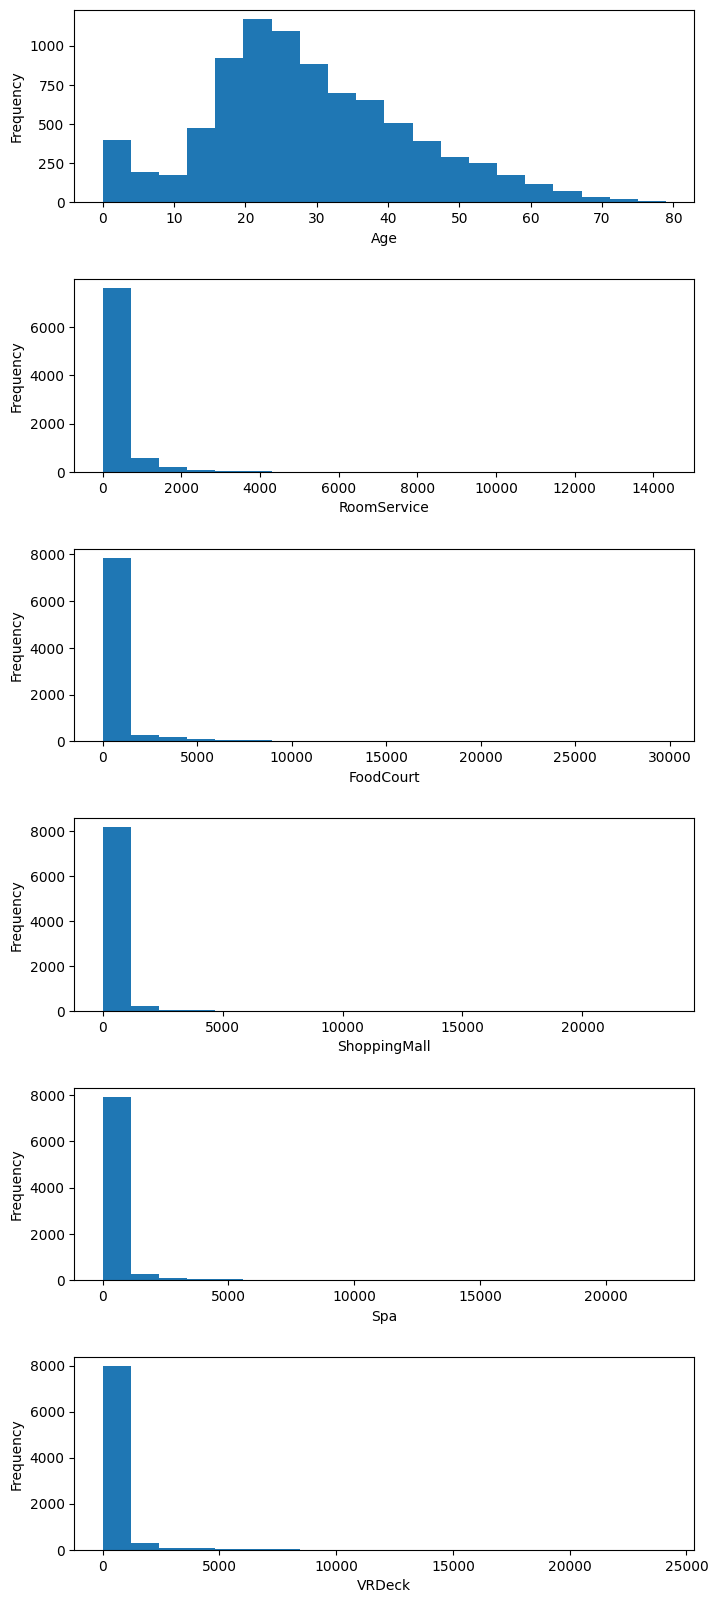

In [ ]:
# Select numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate the number of rows and columns for subplots
nrows = len(numeric_features)
ncols = 1

# Visualize the distributions of numeric features
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 20))
fig.subplots_adjust(hspace=0.4)

for i, column in enumerate(numeric_features):
    ax = axes[i]
    ax.hist(df[column], bins=20)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.show()

Numeric variables have a very skewed distribution, we can normalize them and fill the missing values with the median later.

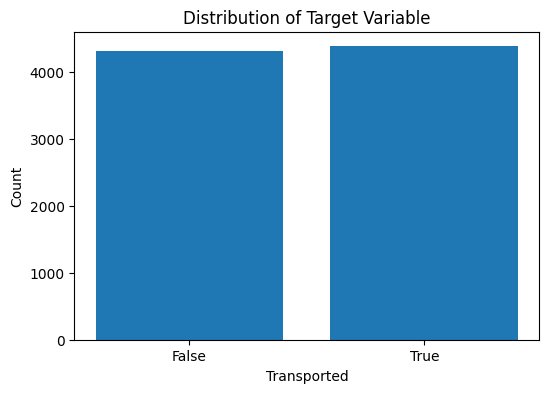

In [ ]:
# Examine the target variable
# Count the occurrences of each clas
class_counts = df['Transported'].value_counts()

# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Transported')
plt.ylabel('Count')
plt.xticks([0, 1], ['False', 'True'])
plt.title('Distribution of Target Variable')
plt.show()

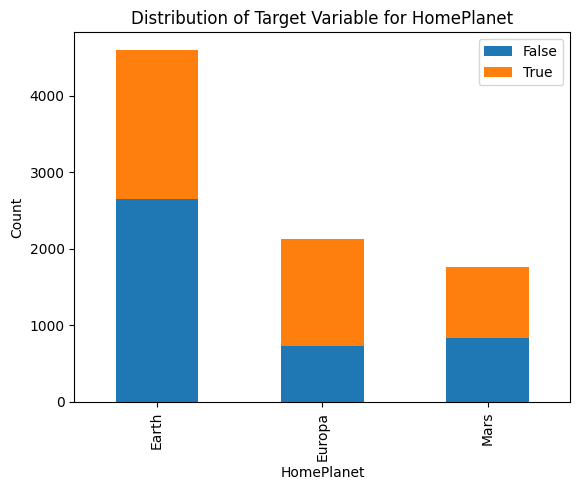

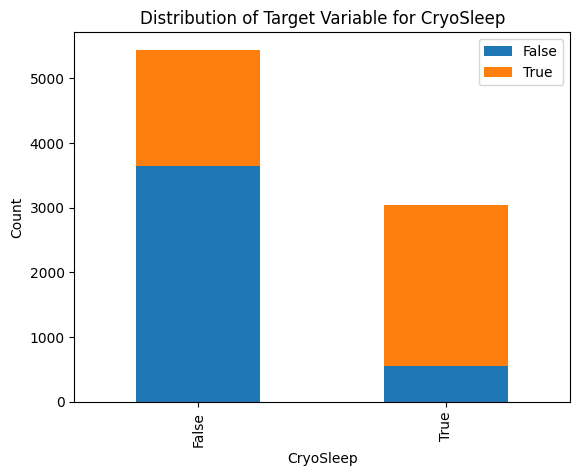

In [ ]:
# Define the categorical features of interest
categorical_features = ['HomePlanet', 'CryoSleep']

# Create bar plots for each categorical feature
for feature in categorical_features:
    # Count the occurrences of each class within the feature
    class_counts = df.groupby(feature)['Transported'].value_counts().unstack()

    # Plot the distribution of the target variable for different categories/levels
    class_counts.plot(kind='bar', stacked=True)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title('Distribution of Target Variable for {}'.format(feature))
    plt.legend(['False', 'True'])
    plt.show()

Notice that CryoSleep variable is an important indicator of whether someone has transferred to the alternate dimension. It's immensely larger for True labeled instances. We might want to drop all the missing values later when preprocessing the data.

In [ ]:
# Find categorical features
categorical_features = df.select_dtypes(include=['object']).columns

# Print number of unique values in each category
for feature in categorical_features:
    unique_count = df[feature].nunique()
    print("Number of unique values in '{}': {}".format(feature, unique_count))


Number of unique values in 'PassengerId': 8693
Number of unique values in 'HomePlanet': 3
Number of unique values in 'CryoSleep': 2
Number of unique values in 'Cabin': 6560
Number of unique values in 'Destination': 3
Number of unique values in 'VIP': 2
Number of unique values in 'Name': 8473


*PassengerId*, *Cabin* and *Name* have high cardinality. But before dropping them, we might want to examine further because we might engineer new features out of them.

### 2. Data Preprocessing & Feature Engineering

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ml-data/train_spaceship.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
# Create preprocessing function so that we can use it on the test set

def preprocessing(df):
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns

    # Fill missing values with median
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Find categorical variables
    categorical_columns = df.select_dtypes(include='object').columns

    # Fill missing values in categorical variables
    df[categorical_columns] = df[categorical_columns].fillna('missing')

    # Convert Boolean values to strings
    df['CryoSleep'] = df['CryoSleep'].astype(str)
    df['VIP'] = df['VIP'].astype(str)
    df['Transported'] = df['Transported'].astype(str)

    # Drop Name
    df.drop('Name', axis=1, inplace=True)



def feature_engineering(df):
    # ---------------------------------------------------------
    # Feature 1) Group Size
    # ---------------------------------------------------------

    # Split the PassengerId column to extract group and individual numbers
    split_ids = df['PassengerId'].str.split('_', expand=True)

    # Extract the group number
    df['Group'] = split_ids[0]

    # Extract the individual number and convert to integer
    df['Individual'] = split_ids[1].astype(int)

    # Calculate the maximum group size
    group_sizes = df.groupby('Group')['Individual'].max()

    # Map the maximum group size to each passenger
    df['GroupSize'] = df['Group'].map(group_sizes)

    # Drop additional features we've created to make GroupSize
    df.drop(['Group', 'Individual', 'PassengerId'], axis=1, inplace=True)

    # ---------------------------------------------------------
    # Feature 2) Cabin Side
    # ---------------------------------------------------------

    # Extract Cabin Side from Cabin variable
    df['CabinSide'] = df['Cabin'].str.split('/').str[-1]

    # ---------------------------------------------------------
    # Feature 3) Cabin Deck
    # ---------------------------------------------------------

    # Extract Cabin Deck from Cabin variable
    df['CabinDeck'] = df['Cabin'].str.split('/').str[0]

    # Drop Cabin since it has high number of unique values
    df.drop(['Cabin'], axis=1, inplace=True)

    # ---------------------------------------------------------
    # Feature 4) Age Categories
    # ---------------------------------------------------------

    # Define the age ranges for the different categories
    age_bins = [0, 10, 18, 30, 50, float('inf')]  # Customize the age ranges as per your preference

    # Define the labels for the age categories
    age_labels = ['Children', 'Teenagers', 'Young Adults', 'Middle-aged', 'Elderly']

    # Create the "AgeGroup" feature by binning the ages
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)


    # ---------------------------------------------------------
    # Feature 5) Total Luxury Spending
    # ---------------------------------------------------------

    # Sum up the luxury spending for each passenger
    df['TotalLuxurySpending'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)


In [ ]:
# Clean and engineer new features to df
preprocessing(df)
feature_engineering(df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Create a function for MinMaxScaler
def min_max_scaling(df):
    scaler = MinMaxScaler()
    numeric_columns = df.select_dtypes(include='number').columns
    df_scaled = df.copy()  # Create a copy of the original dataframe
    df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])
    return df_scaled

# Create a function for StandardScaler
def standard_scaling(df):
    scaler = StandardScaler()
    numeric_columns = df.select_dtypes(include='number').columns
    df_scaled = df.copy()  # Create a copy of the original dataframe
    df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])
    return df_scaled

# Apply MinMaxScaler to numeric columns
df_min_max_scaled = min_max_scaling(df)

# Apply StandardScaler to numeric columns
df_standard_scaled = standard_scaling(df)

In [ ]:
def encode_categorical(df):
    # Get the list of categorical columns excluding 'Transported'
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.drop('Transported')

    # Perform one-hot encoding for categorical columns except 'Transported'
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Transform the independent variable
    df_encoded['Transported'] = df_encoded['Transported'].map({'True': 1, 'False': 0})


    return df_encoded

In [ ]:
# One hot encode the categorical variables
df_encoded_minmax = encode_categorical(df_min_max_scaled)
df_encoded_std = encode_categorical(df_standard_scaled)

### 3. Model Training & HyperParameter Tuning

In [ ]:
from sklearn.model_selection import train_test_split

X_minmax = df_encoded_minmax.drop('Transported', axis=1)
y_minmax = df_encoded_minmax['Transported']

X_train, X_test, y_train, y_test = train_test_split(X_minmax,
                                                    y_minmax,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Create a dictionary for each algorithm
algorithms = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier()
}

# Initialize a dictionary to store the initial scores
base_scores = {}

# Fit each algorithm and calculate initial scores
for name, algorithm in algorithms.items():
    algorithm.fit(X_train, y_train)
    score = algorithm.score(X_test, y_test)
    base_scores[name] = score

# Print the initial scores
for name, score in base_scores.items():
    print(f"{name}: {score}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: 0.7641871165644172
Decision Tree: 0.7381134969325154
Random Forest: 0.7825920245398773
SVM: 0.7553680981595092
Gradient Boosting: 0.7914110429447853
Neural Network: 0.790260736196319


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Create the Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(gbc, param_grid, cv=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
Best Score: 0.8039444706953996
